# Topic 2: Customer Segmentation

In [1]:
import pandas as pd 
import pandas_profiling as pp
import matplotlib.pyplot as plt 
import seaborn as sb 
from datetime import datetime,date
import numpy as np 
from sklearn.cluster import KMeans
import squarify
import scipy
import plotly.express as px

## Bước 1: Business Understanding
### Tìm ra giải pháp giúp cải thiện hiệu quả quảng bá, từ đó giúp tăng doanh thu bán hàng, cải thiện mức độ hài lòng của khách hàng.
### => Mục tiêu/ vấn đề:Xây dựng hệ thống phân cụm khách hàng dựa trên các thông tin do công ty cung cấp từ đó có thể giúp công ty xác định các nhóm khách hàng khác nhau để có chiến lược kinh doanh, chăm sóc khách hàng phù hợp.

## Bước 2: Data Understanding/ Acquire
### Toàn bộ dữ liệu được lưu trữ trong tập tin OnlineRetail.csv với 541.909 record chứa tất cả các giao dịch xảy ra từ ngày 01/12/2010 đến 09/12/2011 đối với bán lẻ trực tuyến

## Bước 3: Data preparation

### Đọc và khám phá dữ liệu

In [2]:
df  = pd.read_csv('OnlineRetail.csv',encoding='cp1252')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,9/12/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,9/12/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,9/12/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,9/12/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,9/12/2011 12:50,4.95,12680.0,France


In [97]:
profile = pp.ProfileReport(df)

In [98]:
profile

Summarize dataset: 22it [00:52,  2.37s/it, Completed]
Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


In [6]:
# Kiểm tra những InvoiceNo có chứa chữ c: it means cancellation ==> Loại bỏ những giao dịch này
df = df[~df['InvoiceNo'].str.contains('C')]

In [7]:
df[df['InvoiceNo'].str.contains('C')].shape[0]

0

In [8]:
# Kiểm tra những giao dịch có quantities <0
df =  df[~df['Quantity']<0]

In [9]:
df[df['Quantity']<0].shape[0]

0

In [10]:
# Kiểm tra những giao dịch không có CustomerID
df =  df[~df['CustomerID'].isnull()]

In [11]:
df[df['CustomerID'].isnull()].shape[0]

0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  float64
 7   Country      397924 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


In [13]:
# Kiểm tra dữ liệu null
df.isnull().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

In [14]:
# Không có dữ liệu null

In [15]:
# Kiểm tra dữ liệu nan
df.isna().any()

InvoiceNo      False
StockCode      False
Description    False
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID     False
Country        False
dtype: bool

In [16]:
# Không có dữ liệu nan

In [17]:
# Vì InvoiceDate có 2 kiểu định dạng ==> Quyết đinh chuyển về kiểu định dạng "%d-%m-%Y"

In [18]:
df1 = df[df['InvoiceDate'].str.contains("-")]

In [19]:
df2 = df[~df['InvoiceDate'].str.contains("-")]

In [20]:
timestamp2 = lambda x: datetime.timestamp(datetime.strptime(x,"%d/%m/%Y %H:%M"))
timestamp1 = lambda x: datetime.timestamp(datetime.strptime(x,"%d-%m-%Y %H:%M"))

In [21]:
df2['timestamp'] = df2['InvoiceDate'].apply(timestamp2)
df1['timestamp'] = df1['InvoiceDate'].apply(timestamp1)

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_1308/2059731317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = df2['InvoiceDate'].apply(timestamp2)
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_1308/2059731317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['timestamp'] = df1['InvoiceDate'].apply(timestamp1)


In [22]:
to_date2 = lambda x : date.fromtimestamp(x).strftime("%Y-%m-%d")
to_date1 = lambda x : date.fromtimestamp(x).strftime("%Y-%m-%d")

In [23]:
df2['InvoiceDate'] = df2['timestamp'].apply(to_date2)
df1['InvoiceDate'] = df1['timestamp'].apply(to_date1)

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_1308/4040474244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['InvoiceDate'] = df2['timestamp'].apply(to_date2)
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_1308/4040474244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['InvoiceDate'] = df1['timestamp'].apply(to_date1)


In [24]:
df2.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,timestamp
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,1.291167e+09


In [25]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,timestamp
26732,538521,21754,HOME BUILDING BLOCK WORD,3,2010-12-13,5.95,14180.0,United Kingdom,1.292206e+09
26733,538521,21755,LOVE BUILDING BLOCK WORD,3,2010-12-13,5.95,14180.0,United Kingdom,1.292206e+09
26734,538521,22072,RED RETROSPOT TEA CUP AND SAUCER,8,2010-12-13,3.75,14180.0,United Kingdom,1.292206e+09
26735,538521,22846,BREAD BIN DINER STYLE RED,1,2010-12-13,16.95,14180.0,United Kingdom,1.292206e+09
26736,538521,22849,BREAD BIN DINER STYLE MINT,1,2010-12-13,16.95,14180.0,United Kingdom,1.292206e+09


In [26]:
df_new = pd.concat([df1,df2],axis=0)

In [27]:
df_new.shape[0]

397924

In [28]:
df.shape[0]

397924

In [29]:
# Chuyển kiểu dữ liệu của InvoiceDate sang datetime64

In [30]:
df_new['InvoiceDate'] = df_new['InvoiceDate'].astype('datetime64[ns]')

In [31]:
df_new = df_new.drop(['timestamp'],axis=1)

In [32]:
df_new.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
26732,538521,21754,HOME BUILDING BLOCK WORD,3,2010-12-13,5.95,14180.0,United Kingdom
26733,538521,21755,LOVE BUILDING BLOCK WORD,3,2010-12-13,5.95,14180.0,United Kingdom
26734,538521,22072,RED RETROSPOT TEA CUP AND SAUCER,8,2010-12-13,3.75,14180.0,United Kingdom
26735,538521,22846,BREAD BIN DINER STYLE RED,1,2010-12-13,16.95,14180.0,United Kingdom
26736,538521,22849,BREAD BIN DINER STYLE MINT,1,2010-12-13,16.95,14180.0,United Kingdom


In [33]:
# Tạo cột Sales
df_new['Sales'] = df_new['Quantity'] * df_new['UnitPrice']

In [34]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 26732 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   Sales        397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [128]:
print('Transaction timeframe from {} to {}'.format(df_new['InvoiceDate'].min(),df_new['InvoiceDate'].max()))
print('{:,} transactions don\'t have a customer id'.format(df_new[df_new['CustomerID'].isnull()].shape[0]))
print('{:,} unique customer_id'.format(len(df_new['CustomerID'].unique())))

Transaction timeframe from 2010-12-01 00:00:00 to 2011-12-09 00:00:00
0 transactions don't have a customer id
4,339 unique customer_id


In [ ]:
df_new

## Create RFM analysis for each customers

In [129]:
df_new.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Sales'],
      dtype='object')

In [130]:
# RFC
# Convert string to date, get max date of df
max_date = df_new['InvoiceDate'].max().date() # Lấy ngày lớn nhất trong cột ngày

Recency = lambda x : (max_date - x.max().date()).days # Lấy ngày lớn nhất - ngày gần đây nhất khách hàng giao dịch
Frequency = lambda x: len(x.unique()) # Lấy khách hàng đó, tìm độ dài của giao dịch duy nhất
Monetary = lambda x: round(sum(x),2)
    
df_RFM = df_new.groupby('CustomerID').agg({'InvoiceDate':Recency,'StockCode':Frequency,'Sales':Monetary})

In [131]:
df_RFM.head()

,InvoiceDate,StockCode,Sales
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,103,4310.00
12348.0,75,22,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [132]:
# Rename the columns of DataFrame
df_RFM.columns = ['Recency','Frequency','Monetary']
# Descending sorting 
df_RFM = df_RFM.sort_values('Monetary',ascending = False)

In [133]:
df_RFM.head()

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,701,280206.02
18102.0,0,150,259657.30
17450.0,8,124,194550.79
16446.0,0,3,168472.50
14911.0,1,1787,143825.06


In [134]:
df_RFM.shape

(4339, 3)

C:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\ADMIN\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hi

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

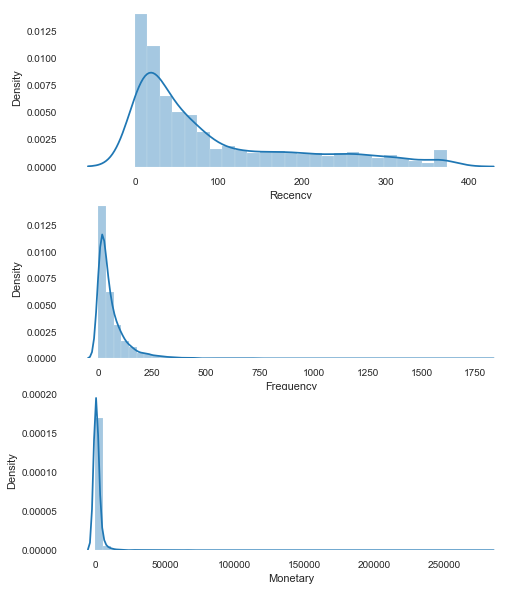

In [135]:
# Visualization
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
sb.distplot(df_RFM['Recency']) # Plot distribution of R
plt.subplot(3,1,2)
sb.distplot(df_RFM['Frequency']) # Plot distribution of F
plt.subplot(3,1,3)
sb.distplot(df_RFM['Monetary']) # Plot distribution of M

In [136]:
for col in df_RFM.columns:
    print(col)
    print("Skewness",df_RFM[col].skew())
    print("Kurtosis",df_RFM[col].kurt())
    print("Mean",df_RFM[col].mean())
    print('-----------------------')

Recency
Skewness 1.2461369784209273
Kurtosis 0.4312416812566804
Mean 92.0414842129523
-----------------------
Frequency
Skewness 6.919373401826159
Kurtosis 99.75223955454275
Mean 61.48928324498733
-----------------------
Monetary
Skewness 19.326985305330293
Kurtosis 478.1513776442003
Mean 2053.7930168241533
-----------------------


#### Nhận xét:
* Dựa vào biểu đồ và skew,kurt của các biến: ta thấy cả 3 biểu đồ của Recency,Frequency,Monetary đều nhọn hơn phân phối chuẩn và đều lệch phải
* Trung bình 92 ngày khách hàng sẽ quay lại
* Trung bình 61 ngày khách hàng sẽ giao dịch 1 lần
* Trung bình 1 lần khách hàng sẽ chi tiêu $2053

## Calcualte RFM quartiles
### Sau khi đã có giá trị của RFM ta tiến hành chia bin ==>Xếp từng cột R,F,M tương ứng vào các bin được xếp

In [137]:
# Create labels for Recency,Frequcency,Monetary
r_labels = range(4,0,-1) # số ngày tính từ lần cuối cùng mua hàng lớn thì gán nhãn nhỏ, ngược lại thì nhãn lớn
f_labels = range(1,5)
m_labels = range(1,5)

In [138]:
# Assign these labels to 4 equal percentile groups
r_groups = pd.qcut(df_RFM.Recency.rank(method='first'),q = 4,labels=r_labels)

f_groups = pd.qcut(df_RFM.Frequency.rank(method='first'),q = 4,labels=f_labels)

m_groups = pd.qcut(df_RFM.Monetary.rank(method='first'),q = 4,labels=m_labels)

In [139]:
# Create new columns R,F,M
df_RFM = df_RFM.assign(R = r_groups.values,F = f_groups.values,M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
14646.0,1,701,280206.02,4,4,4
18102.0,0,150,259657.30,4,4,4
17450.0,8,124,194550.79,4,4,4
16446.0,0,3,168472.50,4,1,4
14911.0,1,1787,143825.06,4,4,4


In [140]:
df_RFM.tail()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
17956.0,249,1,12.75,1,1,1
16454.0,44,2,6.90,3,1,1
14792.0,63,2,6.20,2,1,1
16738.0,297,1,3.75,1,1,1
13256.0,14,1,0.00,4,1,1


## Concat RFM quartile values to create RFM Segments

In [141]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
df_RFM['RFM_Segment'] =df_RFM.apply(join_rfm,axis = 1)

In [142]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
CustomerID,,,,,,,
14646.0,1,701,280206.02,4,4,4,444
18102.0,0,150,259657.30,4,4,4,444
17450.0,8,124,194550.79,4,4,4,444
16446.0,0,3,168472.50,4,1,4,414
14911.0,1,1787,143825.06,4,4,4,444


## Count num of unique segments

In [143]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()

In [144]:
print(rfm_count_unique.sum())

64


#### Nhận xét:
* Sẽ có 64 segments nếu sử dụng phương pháp phân loại này 
* Cần 1 cách tính khác để giảm số nhóm segments phải phân ra

## Calculate RFM Score and level

In [145]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis = 1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
14646.0,1,701,280206.02,4,4,4,444,12.0
18102.0,0,150,259657.30,4,4,4,444,12.0
17450.0,8,124,194550.79,4,4,4,444,12.0
16446.0,0,3,168472.50,4,1,4,414,9.0
14911.0,1,1787,143825.06,4,4,4,444,12.0


In [146]:
df_RFM['RFM_Score'].value_counts()

5.0     533
7.0     479
8.0     474
6.0     439
9.0     438
10.0    425
11.0    416
12.0    394
4.0     379
3.0     362
Name: RFM_Score, dtype: int64

In [147]:
def rfm_level(df):
    if(df['RFM_Score'] in(11,12)):
        return 'VIP'
    elif(df['R'] == 4 and df['F'] == 1 and df['M'] ==1):
        return 'NEW'
    elif(df['RFM_Score'] in (9,10)):
        return 'GOLD'
    elif(df['RFM_Score'] in (8,7)):
        return 'SILVER'
    elif(df['RFM_Score'] in (6,5,4)):
        return 'BRONZE'
    else:
        return 'LOST'


In [148]:
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level,axis = 1)

In [149]:
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
14646.0,1,701,280206.02,4,4,4,444,12.0,VIP
18102.0,0,150,259657.30,4,4,4,444,12.0,VIP
17450.0,8,124,194550.79,4,4,4,444,12.0,VIP
16446.0,0,3,168472.50,4,1,4,414,9.0,GOLD
14911.0,1,1787,143825.06,4,4,4,444,12.0,VIP


### Number of Segments

In [150]:
df_RFM['RFM_Level'].value_counts()

BRONZE    1294
SILVER     953
GOLD       863
VIP        810
LOST       362
NEW         57
Name: RFM_Level, dtype: int64

#### Nhận xét:tỉ lệ các nhóm khá cân bằng 

## Calculate mean values for each segment

In [151]:
# Caluculate average values of each RFM_Level, and return a size of each segment
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(0)
rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean','Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100,2)

In [152]:
# Reset the index
rfm_agg = rfm_agg.reset_index()

In [153]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,BRONZE,148.0,20.0,500.0,1294,29.82
1,GOLD,38.0,76.0,2337.0,863,19.89
2,LOST,260.0,8.0,156.0,362,8.34
3,NEW,8.0,7.0,169.0,57,1.31
4,SILVER,74.0,41.0,908.0,953,21.96
5,VIP,13.0,165.0,6562.0,810,18.67


## Tree Map

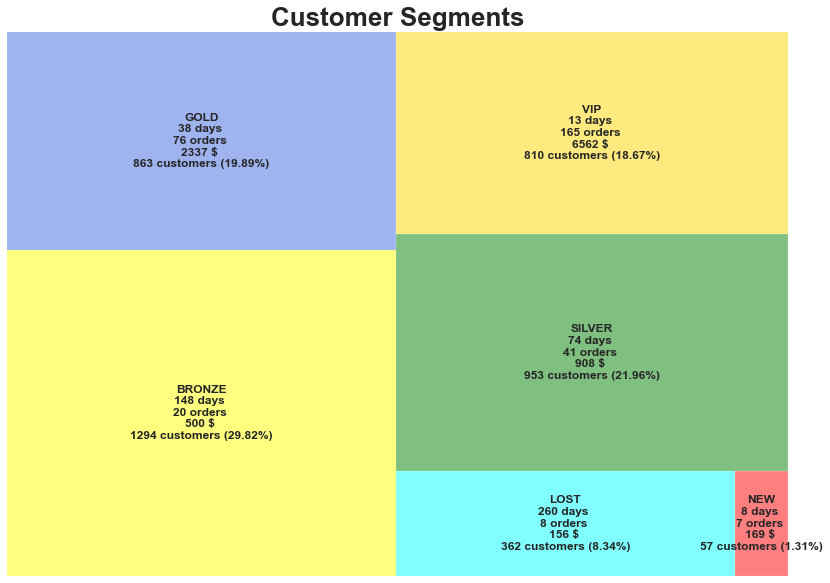

In [154]:
# Create our plot and resize it
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14,10)

color_dict = {'GOLD':'yellow','SILVER':'royalblue','BRONZE':'cyan',\
'LOST':'red','NEW':'green','VIP':'gold'}

squarify.plot(
    sizes=rfm_agg['Count'],
    text_kwargs={'fontsize':12,'weight':'bold','fontname':'sans serif'},
    color=color_dict.values(),
    label=['{}\n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i]) for i in range(0,len(rfm_agg))],
    alpha =0.5
)
plt.title("Customer Segments",fontsize =26,fontweight ='bold')
plt.axis('off')

plt.savefig('RFM Segment.png')
plt.show()

#### Nhận xét từ việc phân loại trên ta có thể đưa ra các nhận xét tổng quan như sau:
* 1/ Các nhóm có tỉ lệ cao là BRONZE(29.82) và SILVER(21.96)
* 2/ Có 8.34% khách hàng sẽ không quay lại
* 3/ Các nhóm khách hàng có khả năng mang lại lợi nhuận cao và đều đặn :VIP,GOLD,SILVER,BRONZE, đặc biệt là lên các kế hoạch đặc biệt nhắm vào nhóm VIP và GOLD
* 4/ Cần tập trung quảng bá đến nhóm khách hàng nêu trên để đạt được hiệu quả tốt nhất

## Scatter Plot(RFM)

In [155]:
fig = px.scatter(rfm_agg,x = 'RecencyMean',y='MonetaryMean',size = 'FrequencyMean',color='RFM_Level',hover_name='RFM_Level',size_max=100)
fig.show()

## 3D Plot

In [156]:
fig = px.scatter_3d(df_RFM,x='Recency',y='Frequency',z='Monetary',color='RFM_Level',opacity=0.5,color_discrete_map=color_dict)
fig.update_traces(marker = dict(size = 5),selector=dict(mode = 'markers'))
fig.show()

In [157]:
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,BRONZE,148.0,20.0,500.0,1294,29.82
1,GOLD,38.0,76.0,2337.0,863,19.89
2,LOST,260.0,8.0,156.0,362,8.34
3,NEW,8.0,7.0,169.0,57,1.31
4,SILVER,74.0,41.0,908.0,953,21.96
5,VIP,13.0,165.0,6562.0,810,18.67


### Nhận xét:Dựa theo dữ liệu thu thập được, chưa sử dụng thuật toán Machine Learning, có thể phân loại khách hàng thành các nhóm sau:
* 1.VIP:Nhóm khách hàng mua hàng nhiều, và chi tiêu nhiều tiền(>$6000)
* 2.GOLD: Nhóm khách hàng đều đặn,và chi tiêu khá nhiều($2337)
* 3.SILVER: Nhóm khách hàng thỉnh thoảng mua hàng, và chi tiêu vừa phải($908)
* 4.BRONZE: Nhóm khách hàng ít mua hàng, và số tiền họ chi  tiêu không quá cao($500)
* 5.NEW: Nhóm khách hàng mới mua hàng
* 6.LOST: Nhóm khách hàng không quay lại mua hàng

### Dựa trên kết quả phân cụm không sủ dụng thuật toán ML, ta thấy các nhóm không chồng chéo lên nhau,nên ta sử dụng thuật toán KMeans để phân cụm khách hàng

## Sử dụng thuật toán Kmeans cluster with Elbow Method

In [241]:
df_now  = df_RFM[['Recency','Frequency','Monetary']]
df_now

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,701,280206.02
18102.0,0,150,259657.30
17450.0,8,124,194550.79
16446.0,0,3,168472.50
14911.0,1,1787,143825.06
...,...,...,...
17956.0,249,1,12.75
16454.0,44,2,6.90
14792.0,63,2,6.20


In [242]:
from sklearn.cluster import KMeans

In [160]:
sse = {}
for k in range(1,20):
    kmeans = KMeans(n_clusters=k,random_state=42)
    kmeans.fit(df_now)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

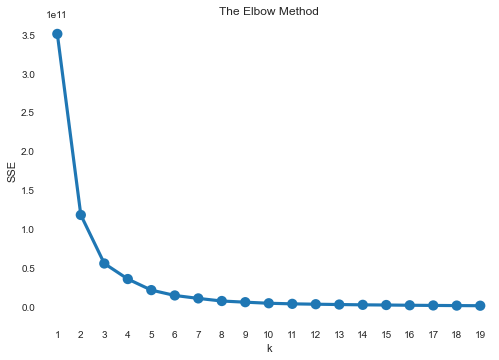

In [161]:
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sb.pointplot(x=list(sse.keys()),y =list(sse.values()))
plt.show()

### Dựa vào thuật toán KMeans và phương pháp Elbow Method, ta có thể phân nhóm khách hàng thành 5 cụm riêng biệt

In [296]:
# Build model with k = 5
model = KMeans(n_clusters=6,random_state=0)
model.fit(df_now)
model.labels_.shape

(4339,)

In [297]:
df_now['Cluster'] = model.labels_

<ipython-input-297-5ae4d061572c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [298]:
df_now

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
14646.0,1,701,280206.02,2
18102.0,0,150,259657.30,2
17450.0,8,124,194550.79,1
16446.0,0,3,168472.50,1
14911.0,1,1787,143825.06,1
...,...,...,...,...
17956.0,249,1,12.75,0
16454.0,44,2,6.90,0
14792.0,63,2,6.20,0


In [299]:
df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(2)

Recency Frequency   Monetary      
           mean      mean       mean count
Cluster                                   
0        100.37     47.53     847.11  3855
1          8.40    614.40  149828.50     5
2          0.50    425.50  269931.66     2
3         45.86    335.57   62969.52    14
4         13.00    202.23   24535.24    39
5         26.55    158.14    5939.50   424

In [300]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_agg2 =  df_now.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean','count']
}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean','Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100,2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change the Cluster Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster' + rfm_agg2['Cluster'].astype('str')

In [301]:
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster0,100.0,48.0,847.0,3855,88.85
1,Cluster1,8.0,614.0,149829.0,5,0.12
2,Cluster2,0.0,426.0,269932.0,2,0.05
3,Cluster3,46.0,336.0,62970.0,14,0.32
4,Cluster4,13.0,202.0,24535.0,39,0.90
5,Cluster5,27.0,158.0,5939.0,424,9.77


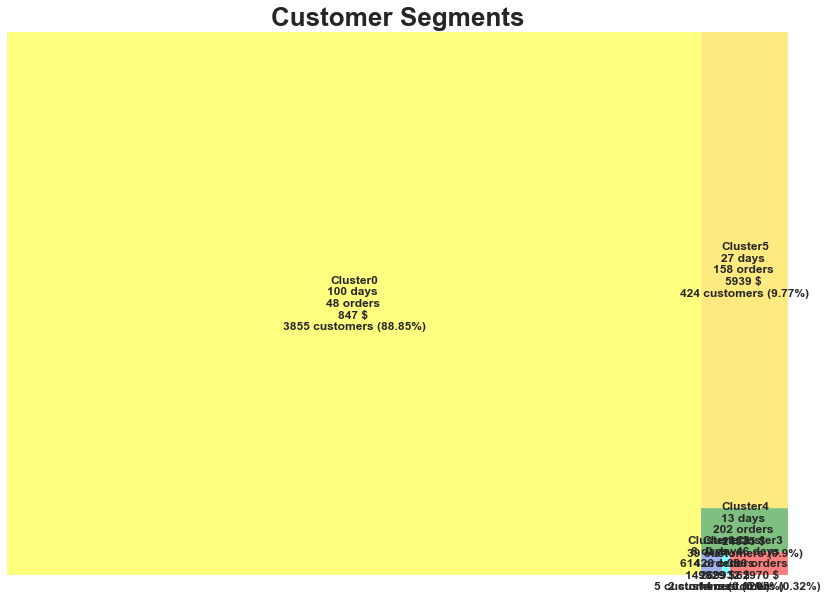

In [312]:
# Create our plot and resize it 
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(14,10)

color_dict2 = {'ACTIVE':'yellow','SPENDER':'royalblue','LIGHT':'cyan',\
'LOST':'red','LOYAL':'purple','POTENTIAL':'green','STARS':'gold'}

squarify.plot(
    sizes=rfm_agg2['Count'],
    text_kwargs={'fontsize':12,'weight':'bold','fontname':'sans serif'},
    color=color_dict.values(),
    label=['{}\n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i]) for i in range(0,len(rfm_agg2))],
    alpha =0.5
)
plt.title("Customer Segments",fontsize =26,fontweight ='bold')
plt.axis('off')

plt.savefig('RFM Segment.png')
plt.show()

In [309]:
# 3d
fig = px.scatter_3d(rfm_agg2,x='RecencyMean',y='FrequencyMean',z='MonetaryMean',color='Cluster',opacity=0.3)
fig.update_traces(marker = dict(size = 20),selector=dict(mode = 'markers'))
fig.show()

In [311]:
fig = px.scatter(rfm_agg2,x = 'RecencyMean',y='MonetaryMean',size = 'FrequencyMean',color='Cluster',hover_name='Cluster',size_max=100)
fig.show()

#### Nhận xét:Dựa vào các kết quả và biểu đồ trên, có thể phân khách hàng thành các nhóm sau
* 1.Cluster 2(Nhóm VIP): nhóm khách hàng rất thường xuyên mua hàng,mua rất nhiều, và chi tiêu rất nhiều tiền để mua hàng.RecencyMean = 0,MonetaryMean = 269k,FrequencyMean = 426
* 2.Cluster 1(Nhóm GOLD): nhóm khách hàng thường xuyên mua hàng,mua nhiều, và chi tiêu nhiều tiền để mua hàng.RecencyMean = 8,MonetaryMean = 149k,FrequencyMean = 614
* 3.Cluster 4(Nhóm SILVER): nhóm khách hàng thường xuyên mua hàng,mua khá nhiều, và chi tiêu tiền ở mức khá để mua hàng.RecencyMean = 13,MonetaryMean = 24k,FrequencyMean = 202
* 4.Cluster 0(Nhóm BRONZE): nhóm khách hàng ít mua hàng,mua ít, và chi ít tiêu để mua hàng.RecencyMean = 100,MonetaryMean = 847,FrequencyMean = 48
* 5.Cluster 3(Nhóm POTENTIAL): nhóm khách hàng thỉnh thoảng mua hàng,mua khá nhiều, và chi tiêu khá nhiều để mua hàng.RecencyMean = 46,MonetaryMean = 62k,FrequencyMean = 336
* 6.Cluster 5(Nhóm REGULAR): nhóm khách hàng thường mua hàng,mua khá nhiều, và chi tiêu trung bình để mua hàng.RecencyMean = 27,MonetaryMean = 5k,FrequencyMean = 158


## Bước 5.Đánh giá

### Đánh giá: kết quả phân nhóm của thuật toán KMeans khá giống với việc phân cụm manual, khác biệt nằm ở tỉ lệ của các nhóm.Kết quả này chấp nhận được

## Bước 6:Deployment

### Dựa vào kết quả phân cụm trên,các chiến dịch cần đưa ra là:
* 1.Có chiến dịch chăm sóc đặc biệt cho các khách hàng thuộc nhóm VIP,và GOLD để giữ họ ở lại với cửa hàng lâu nhất có thể
* 2.Với các khách hàng thuộc nhóm POTENTIAL, cần có các chiến dịch để thu hút họ đến với của hàng nhiều hơn
* 3.Với các khách hàng thuộc nhóm REGULAR, cần có các chiến dịch để kích thích nhu cầu mua sắm của họ --> Kiếm thêm doanh thu từ họ
* 4.Với các nhóm SILVER,BRONZE: chạy các chiến dịch thông thường để họ tiếp tục ở lại với cửa hàng